In [1]:
import numpy as np

findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

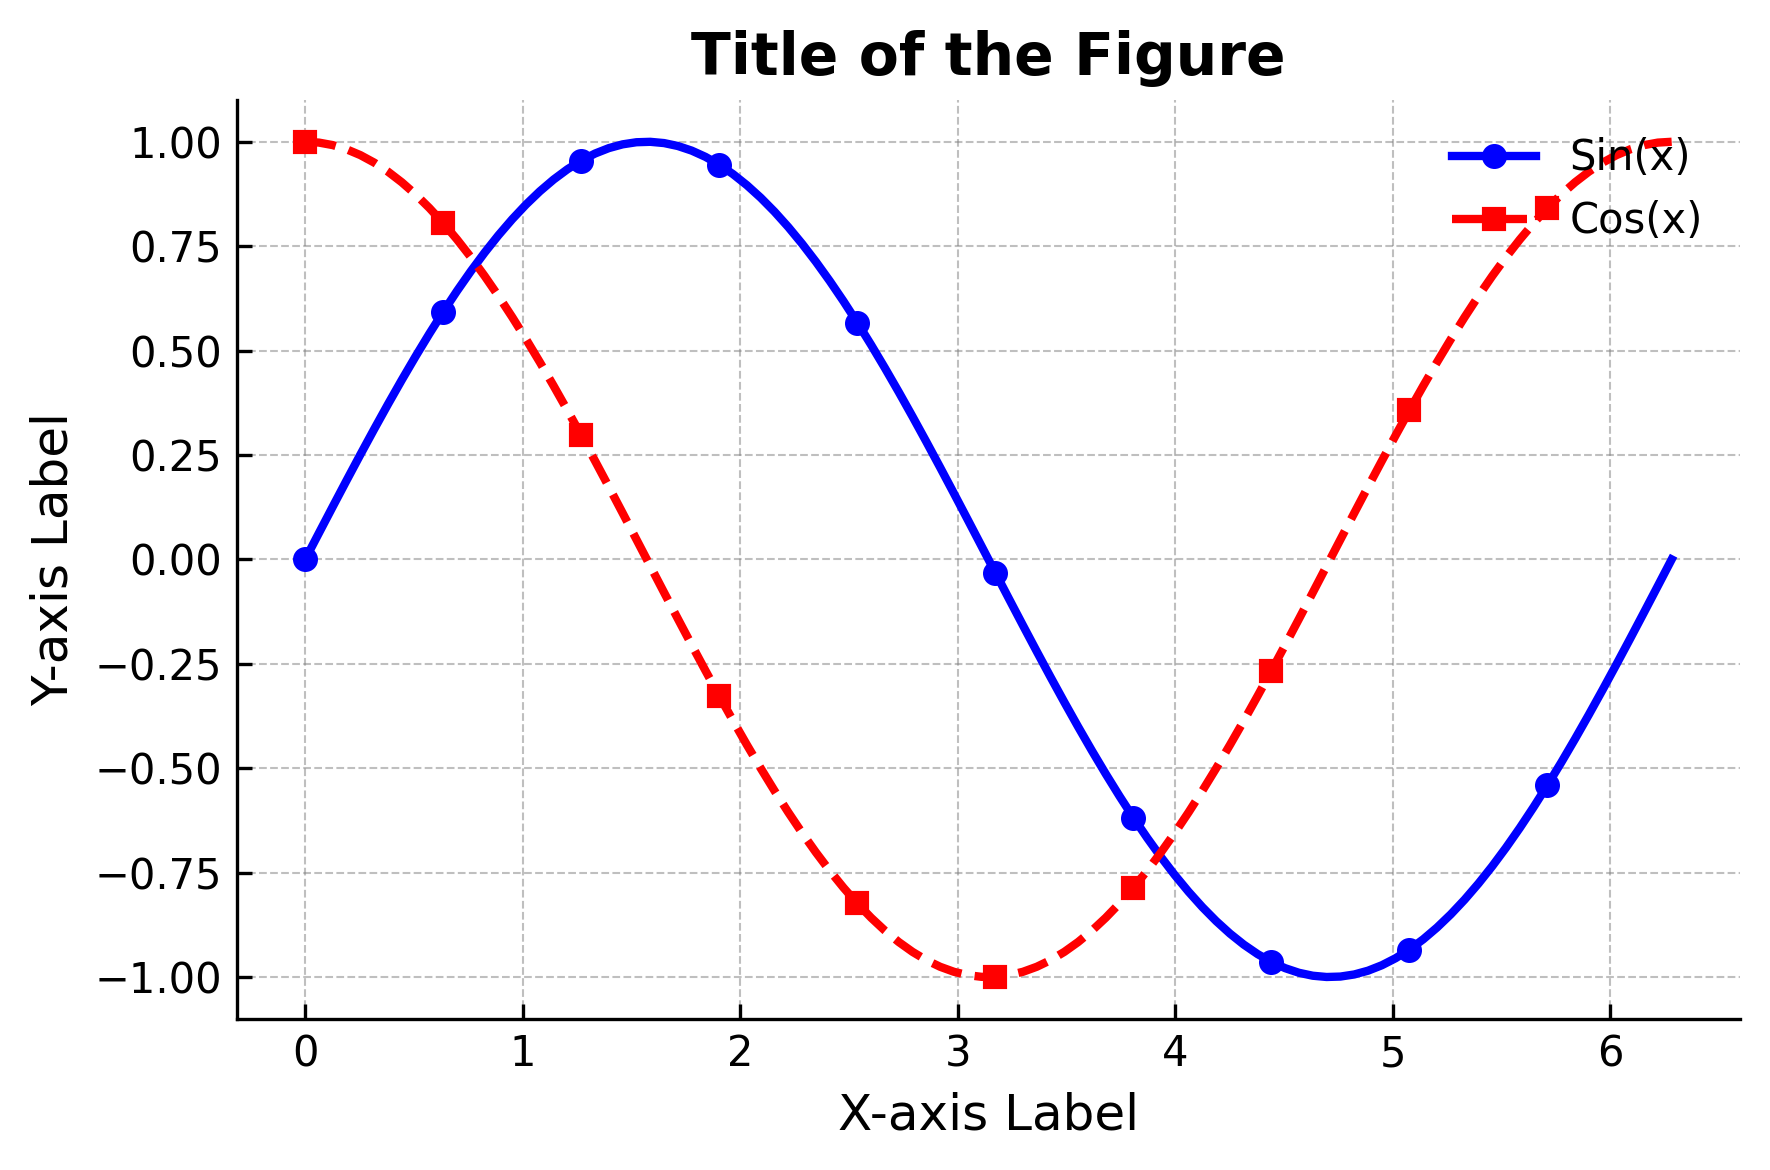

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.linspace(0, 2*np.pi, 100)
y1 = np.array(x)
y2 = np.cos(x)

# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Set plot style with line and markers
ax.plot(x, y1, label='Sin(x)', color='b', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=10)
ax.plot(x, y2, label='Cos(x)', color='r', linewidth=2, marker='s', markersize=5, linestyle='--', markevery=10)

# Set axis labels
ax.set_xlabel('X-axis Label', fontsize=12)
ax.set_ylabel('Y-axis Label', fontsize=12)

# Set title
ax.set_title('Title of the Figure', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set font style
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Times New Roman'
# plt.rcParams['font.size'] = 10

# Set figure layout
fig.tight_layout()

# Save figure
# fig.savefig('figure.png', dpi=300, bbox_inches='tight')

# Show figure
plt.show()


/tmp/ipykernel_13538/2606627223.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.plot(np.linspace(0, 5, 5, dtype=np.int), np.array(eff_rate_difnum), label='Yao et.al', color='g', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=1)
/tmp/ipykernel_13538/2606627223.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify th

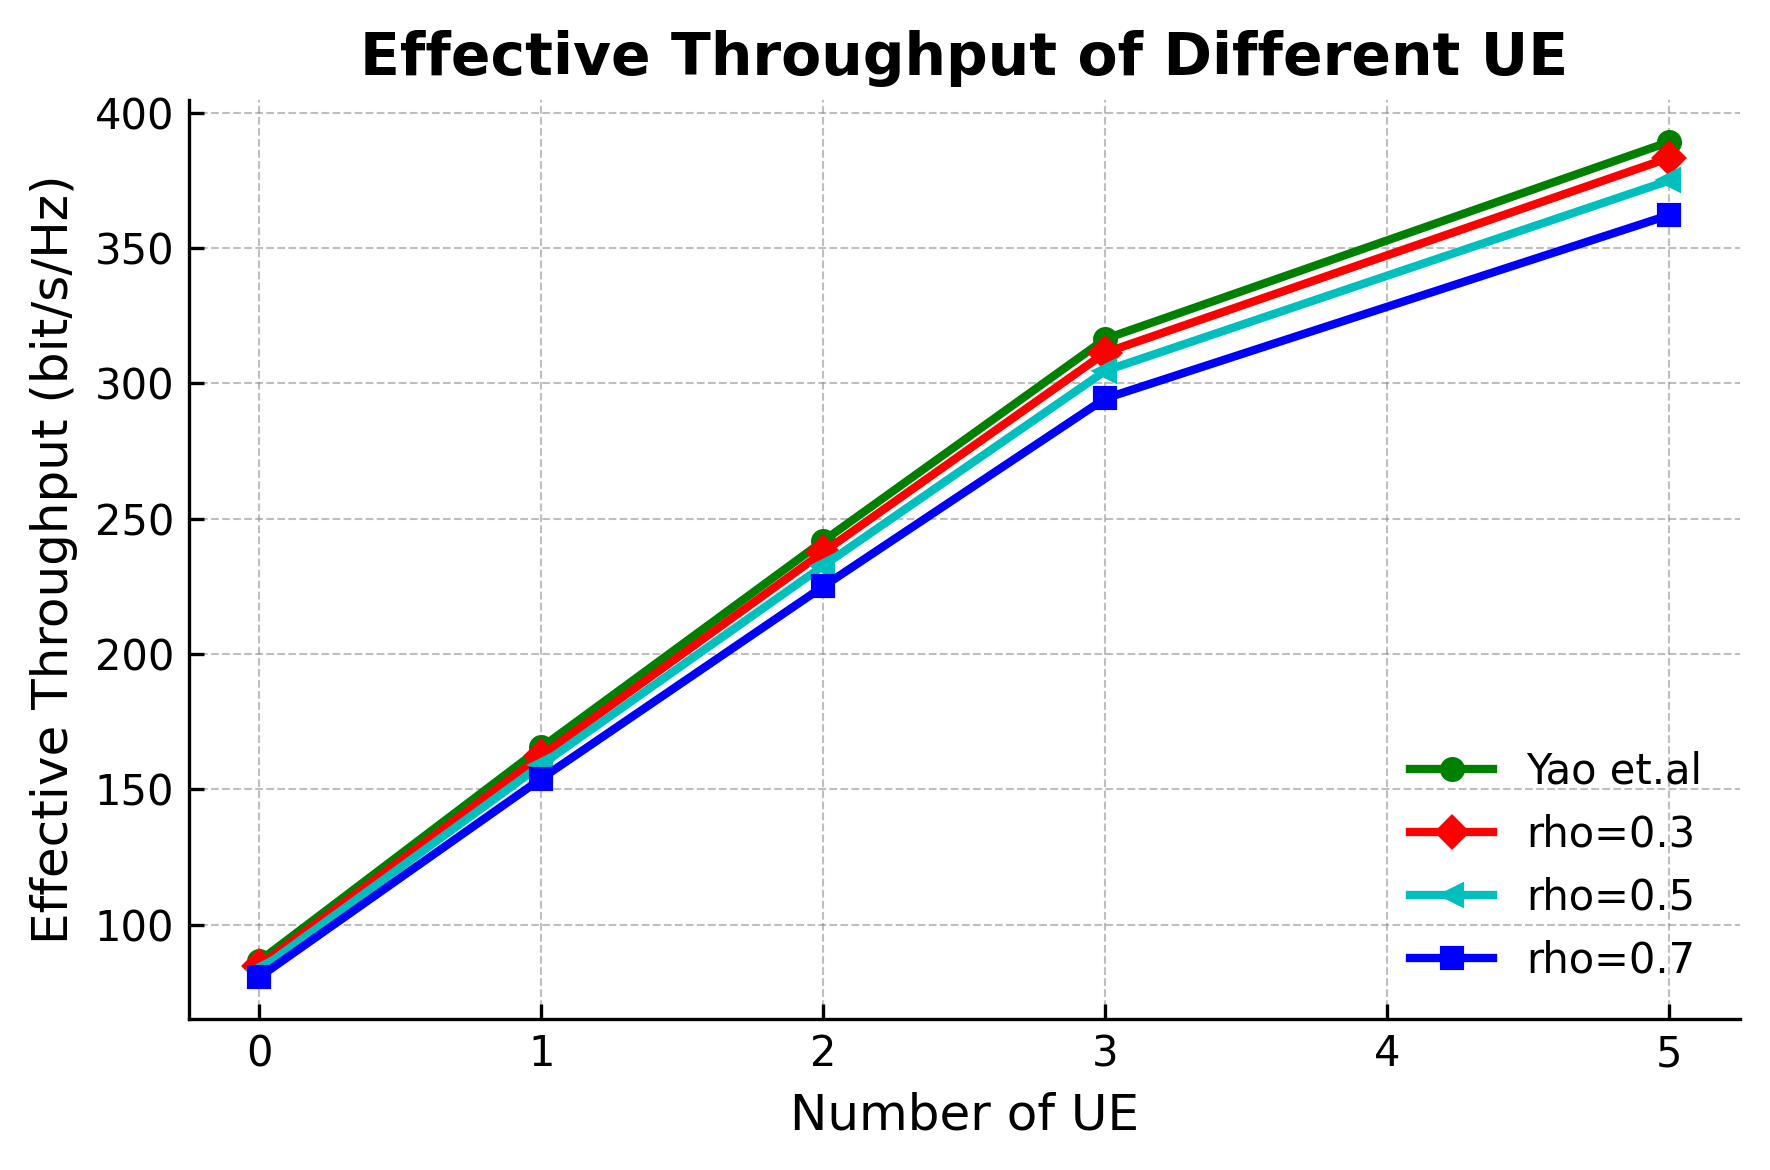

In [58]:
eff_rate_difnum=[86.51678647827585, 165.44971035442512, 241.8140037477916, 316.48760579131766, 389.31913622802324]
eff_rate_0_3=[84.86571907174314, 162.44569263543536, 237.7061144945365, 311.4067061188301, 383.4044989165383]
eff_rate_0_5=[83.18340642033942, 159.08223786725532, 232.66539228647417, 304.6946797605182, 375.0180837208154]
eff_rate_0_7=[80.62928993269347, 153.97430068389326, 225.00457469975134, 294.4826284915723, 362.2537301474447]
# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Set plot style with line and markers
ax.plot(np.linspace(0, 5, 5, dtype=np.int), np.array(eff_rate_difnum), label='Yao et.al', color='g', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=1)
ax.plot(np.linspace(0, 5, 5, dtype=np.int), np.array(eff_rate_0_3), label='rho=0.3', color='r', linewidth=2, marker='D', markersize=5, linestyle='-', markevery=1)
ax.plot(np.linspace(0, 5, 5, dtype=np.int), np.array(eff_rate_0_5), label='rho=0.5', color='c', linewidth=2, marker='<', markersize=5, linestyle='-', markevery=1)
ax.plot(np.linspace(0, 5, 5, dtype=np.int), np.array(eff_rate_0_7), label='rho=0.7', color='b', linewidth=2, marker='s', markersize=5, linestyle='-', markevery=1)
# Set axis labels
ax.set_xlabel('Number of UE', fontsize=12)
ax.set_ylabel('Effective Throughput (bit/s/Hz)', fontsize=12)

# Set title
ax.set_title('Effective Throughput Benchmark', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='lower right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()

# Show figure
plt.show()

In [18]:
import pickle
fp = open('data.pickle', 'rb')
data = pickle.load(fp)

In [19]:
loss_s=[]
reward_s=[]
ue_c_tp_s=[]
ue_acc_s=[]
eff_tp_s=[]
bl_eff_tp_s=[]

In [20]:
loss_s=data[0]
reward_s=data[1]
ue_c_tp_s=data[2]
ue_acc_s=data[3]
eff_tp_s=data[4]
bl_eff_tp_s=data[5]

In [33]:
x = np.linspace(0, 100, 100, dtype=np.int)
# len(loss_s)
x

/tmp/ipykernel_13538/2876219418.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.linspace(0, 100, 100, dtype=np.int)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98, 100])

In [41]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 100, 100, dtype=np.int)
y_loss = np.array(loss_s)
y_reward = np.array(reward_s)
y_eff_tp_s = np.array(eff_tp_s)
bl_eff_tp_s = np.array(bl_eff_tp_s)

/tmp/ipykernel_13538/1495101816.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.linspace(0, 100, 100, dtype=np.int)


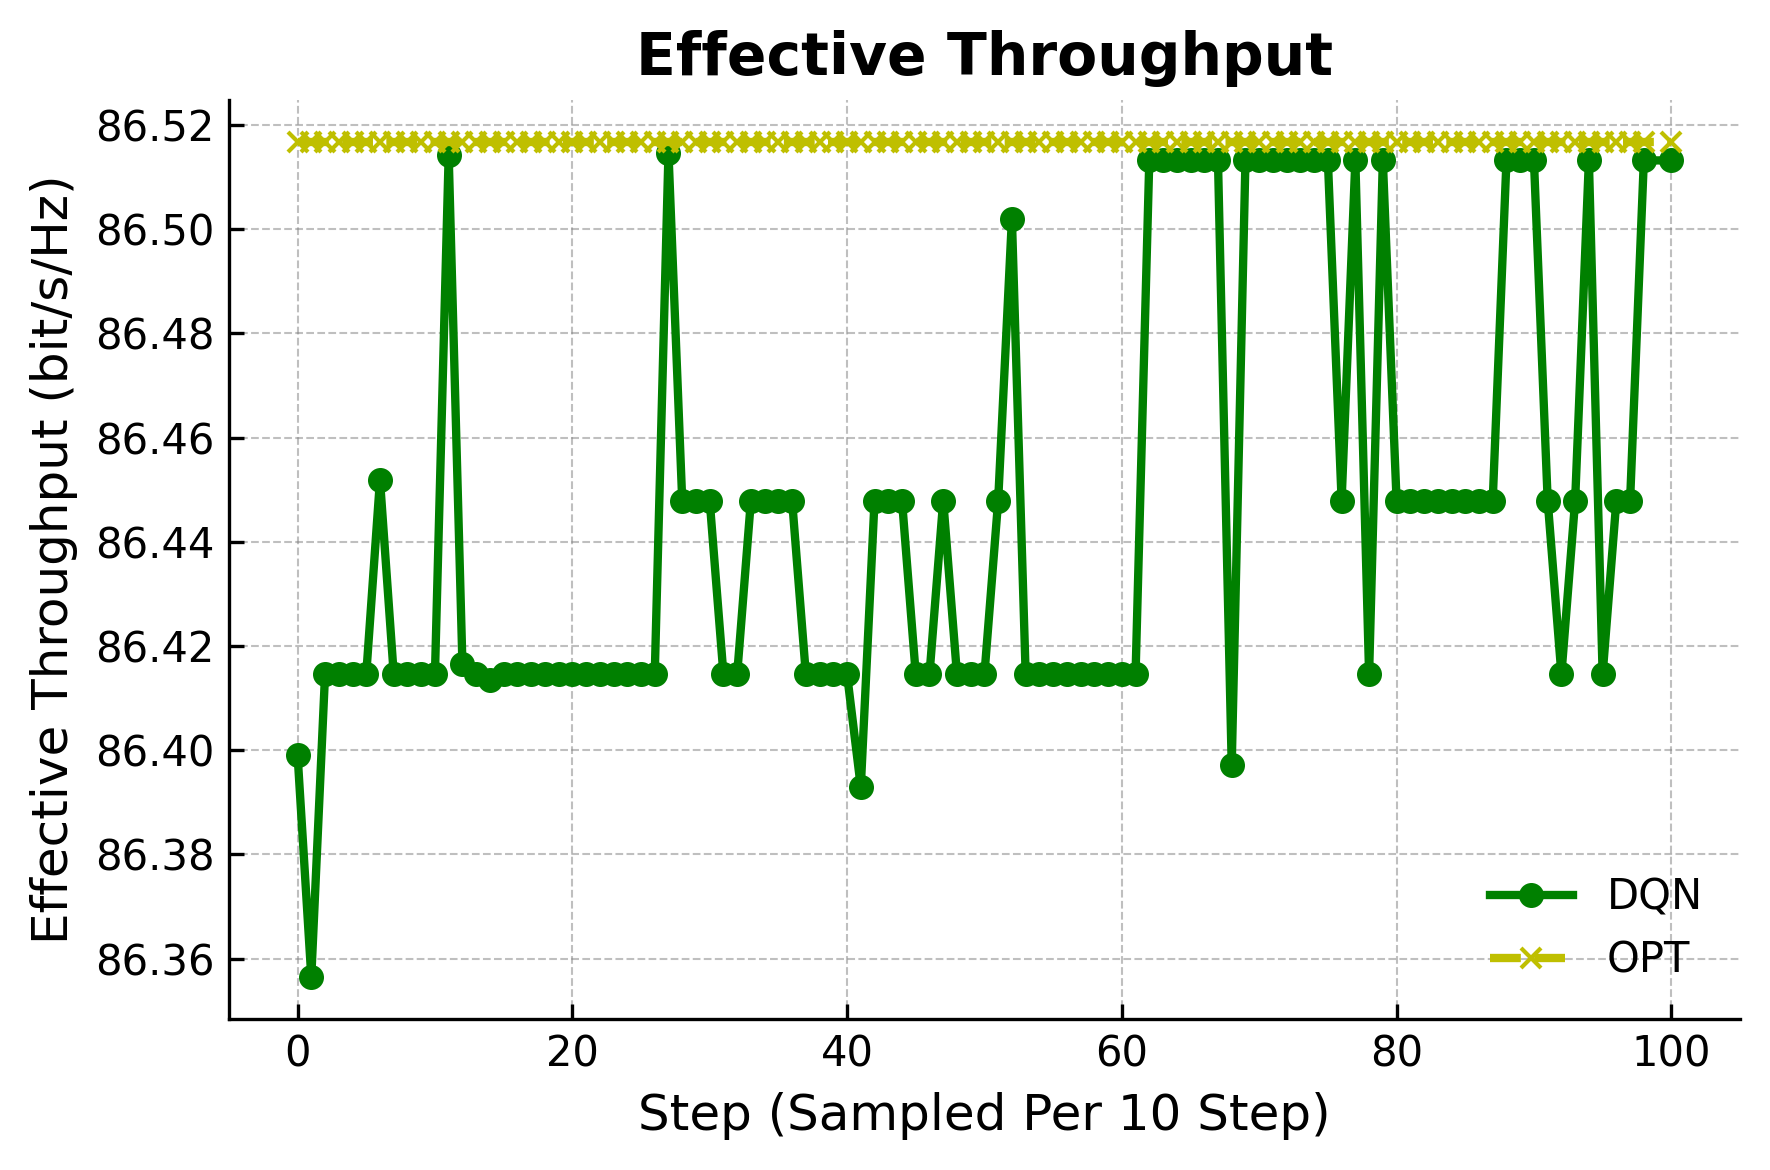

In [46]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Set plot style with line and markers
ax.plot(x, y_eff_tp_s, label='DQN', color='g', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=1)
ax.plot(x, bl_eff_tp_s, label='OPT', color='y', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)

# Set axis labels
ax.set_xlabel('Step (Sampled Per 10 Step)', fontsize=12)
ax.set_ylabel('Effective Throughput (bit/s/Hz)', fontsize=12)

# Set title
ax.set_title('Effective Throughput', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='lower right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()

# Show figure
plt.show()

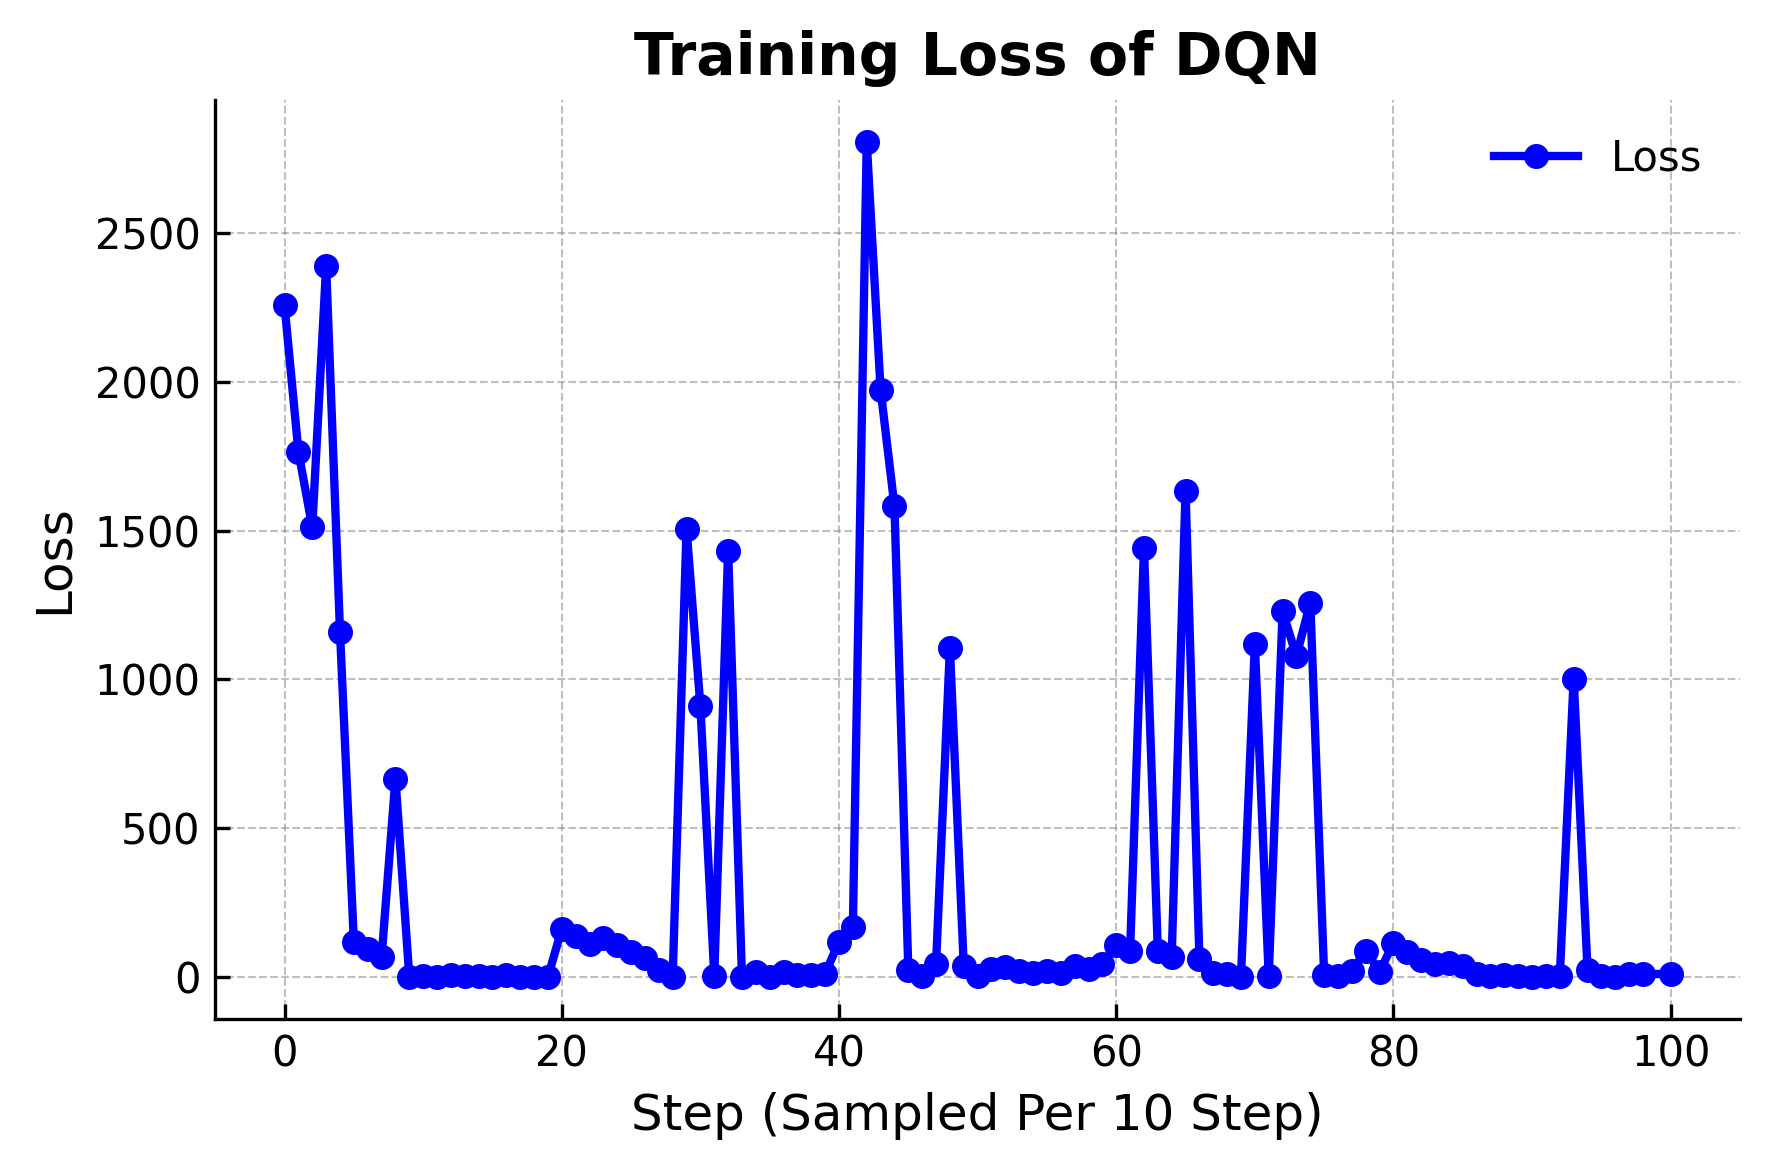

In [37]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)

# Set plot style with line and markers
ax.plot(x, y_loss, label='Loss', color='b', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=1)
# ax.plot(x, y2, label='Cos(x)', color='r', linewidth=2, marker='s', markersize=5, linestyle='--', markevery=10)

# Set axis labels
ax.set_xlabel('Step (Sampled Per 10 Step)', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Set title
ax.set_title('Training Loss of DQN', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()

# Show figure
plt.show()

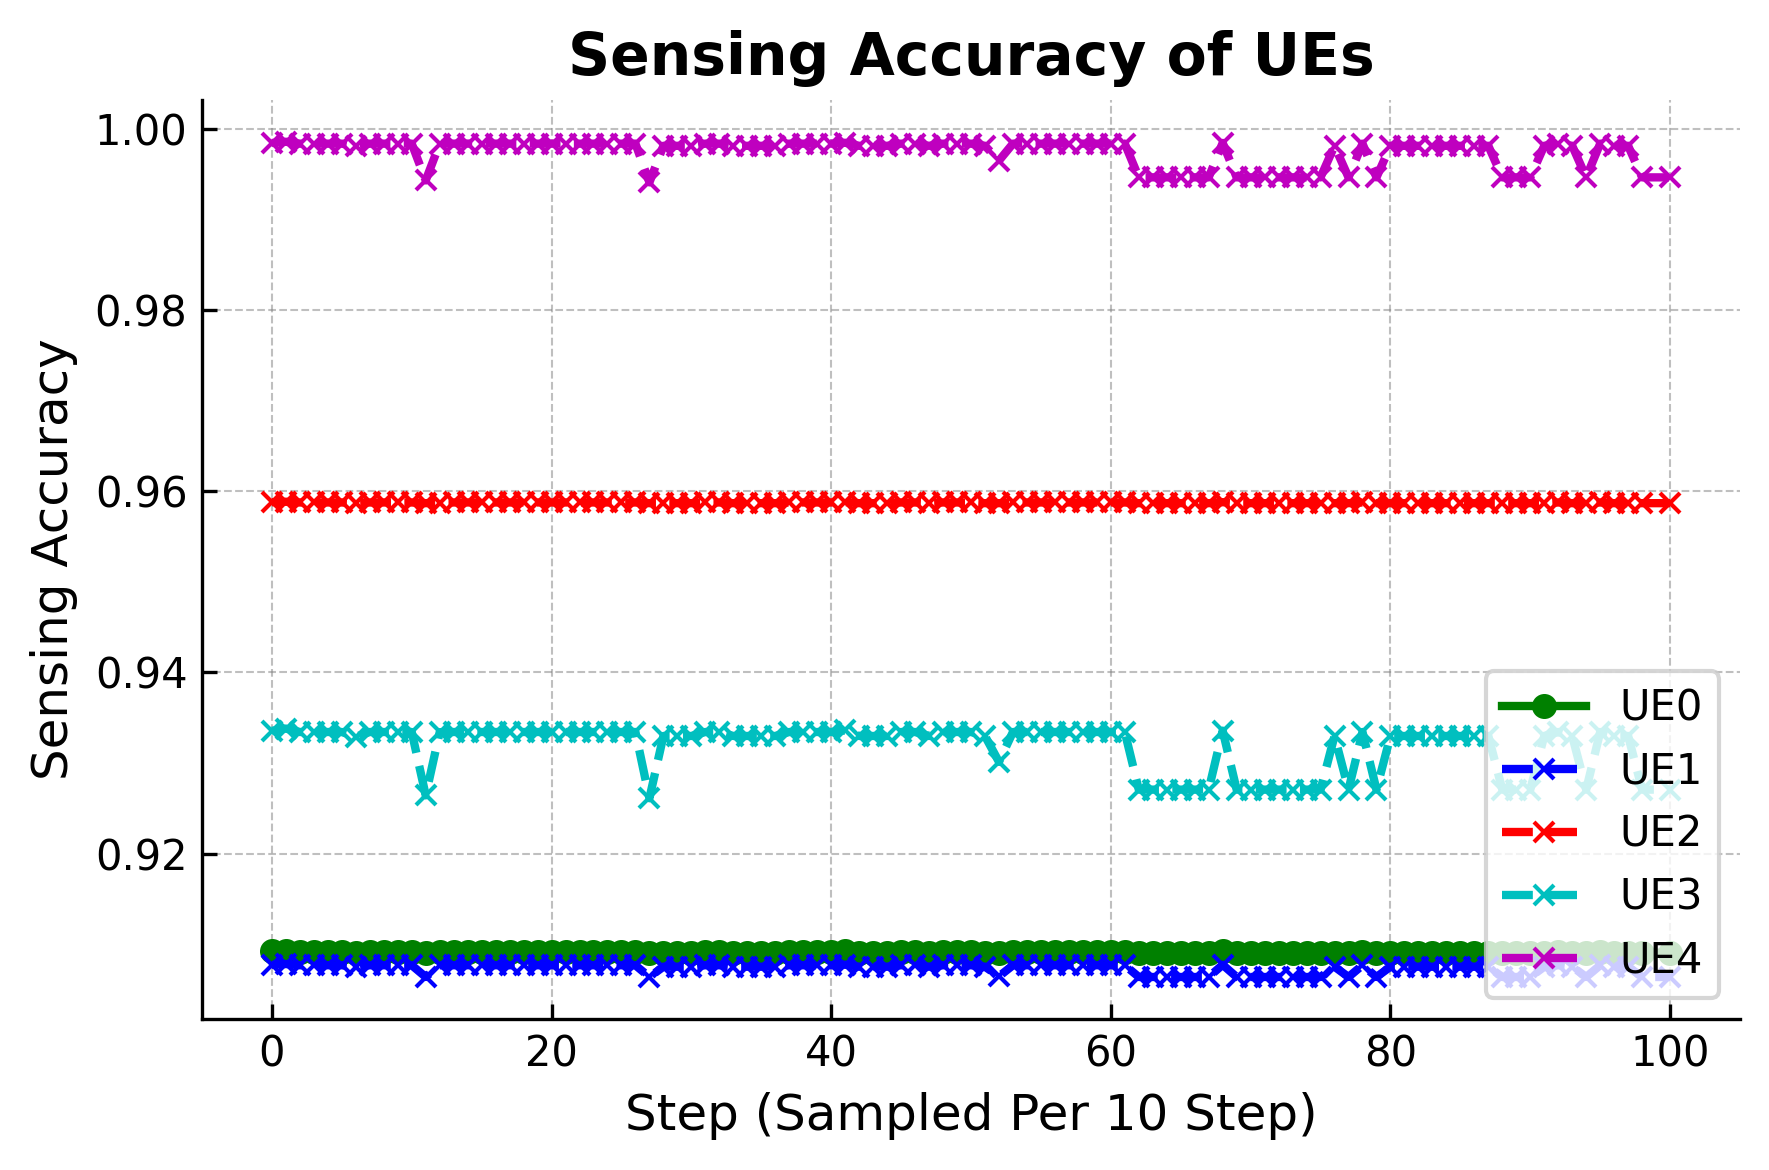

In [49]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ue_acc_s
# Set plot style with line and markers
ax.plot(x, np.array(ue_acc_s[0]), label='UE0', color='g', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=1)
ax.plot(x, np.array(ue_acc_s[1]), label='UE1', color='b', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)
ax.plot(x, np.array(ue_acc_s[2]), label='UE2', color='r', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)
ax.plot(x, np.array(ue_acc_s[3]), label='UE3', color='c', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)
ax.plot(x, np.array(ue_acc_s[4]), label='UE4', color='m', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)

# Set axis labels
ax.set_xlabel('Step (Sampled Per 10 Step)', fontsize=12)
ax.set_ylabel('Sensing Accuracy', fontsize=12)

# Set title
ax.set_title('Sensing Accuracy of UEs', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='lower right', fontsize=10, frameon=True)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()

# Show figure
plt.show()

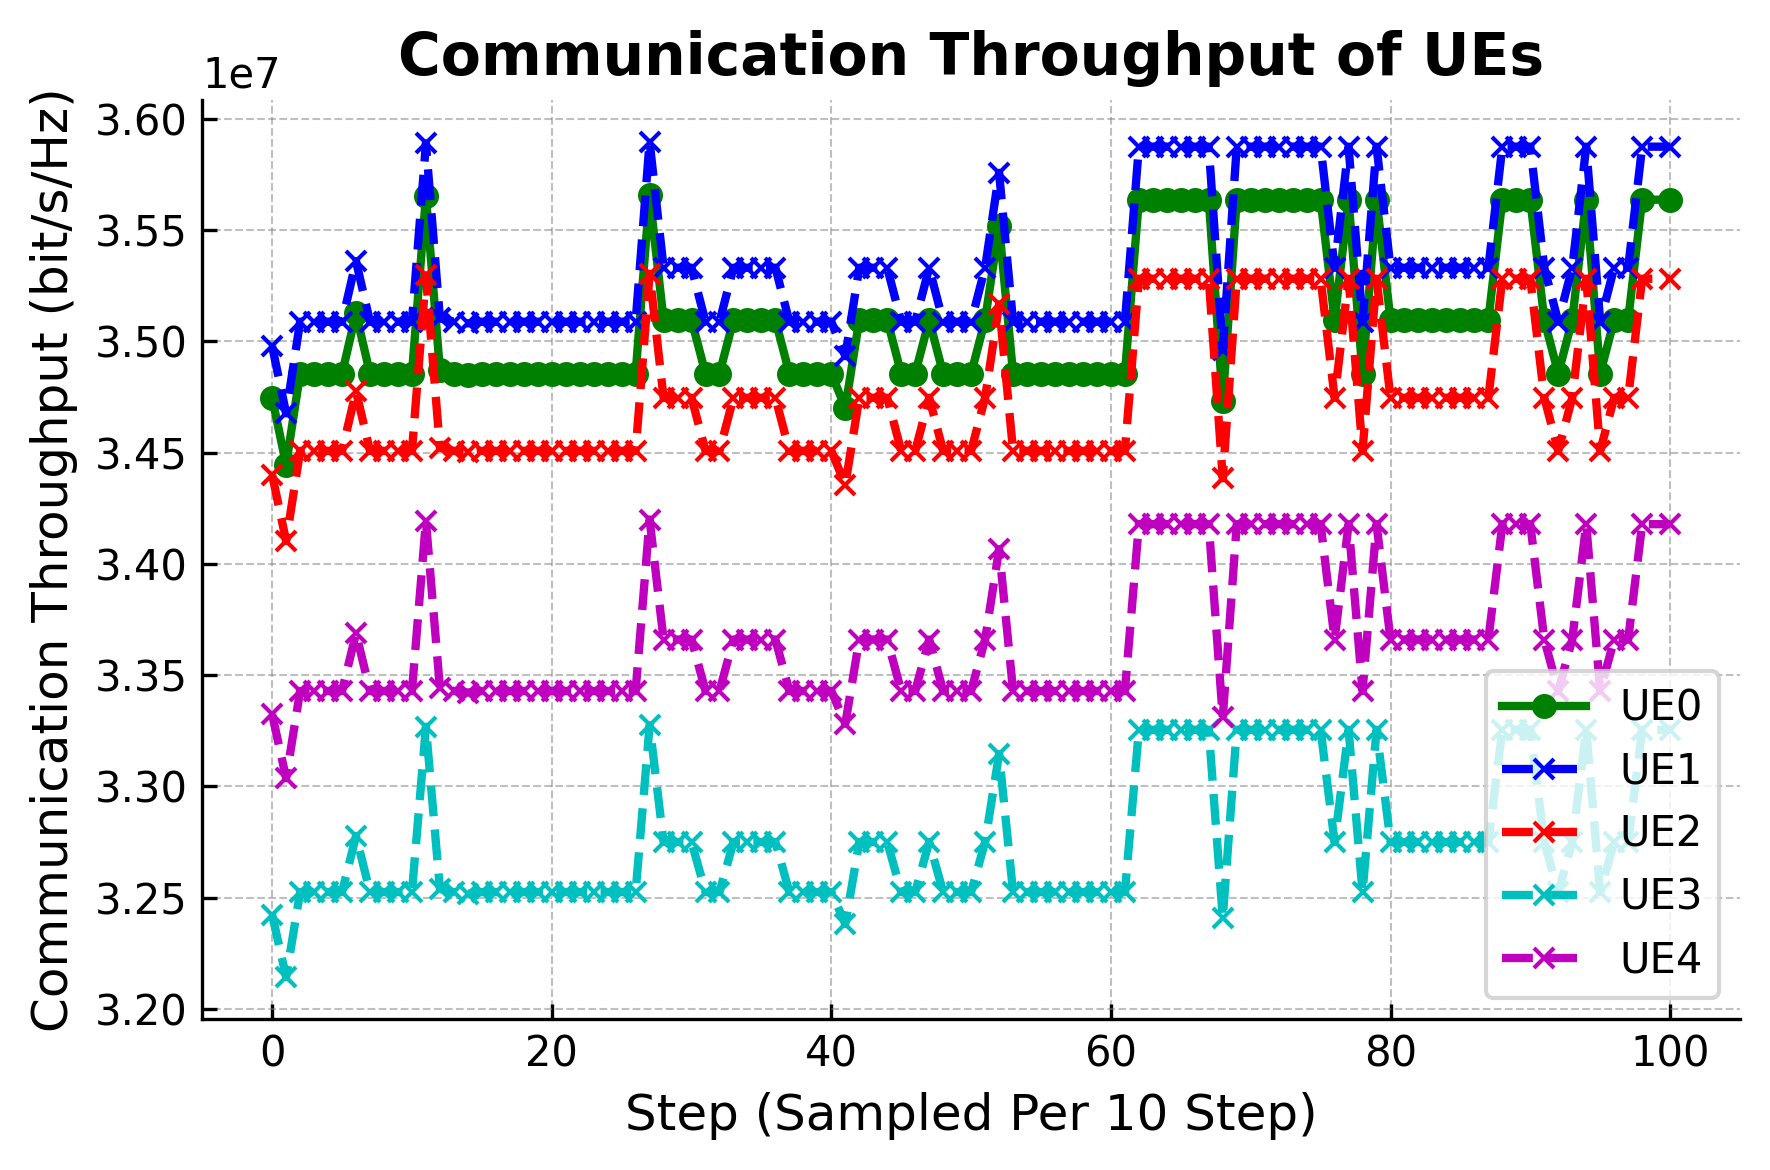

In [50]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
ue_acc_s
# Set plot style with line and markers
ax.plot(x, np.array(ue_c_tp_s[0]), label='UE0', color='g', linewidth=2, marker='o', markersize=5, linestyle='-', markevery=1)
ax.plot(x, np.array(ue_c_tp_s[1]), label='UE1', color='b', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)
ax.plot(x, np.array(ue_c_tp_s[2]), label='UE2', color='r', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)
ax.plot(x, np.array(ue_c_tp_s[3]), label='UE3', color='c', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)
ax.plot(x, np.array(ue_c_tp_s[4]), label='UE4', color='m', linewidth=2, marker='x', markersize=5, linestyle='--', markevery=1)

# Set axis labels
ax.set_xlabel('Step (Sampled Per 10 Step)', fontsize=12)
ax.set_ylabel('Communication Throughput (bit/s/Hz)', fontsize=12)

# Set title
ax.set_title('Communication Throughput of UEs', fontsize=14, fontweight='bold')

# Set legend
ax.legend(loc='lower right', fontsize=10, frameon=True)

# Set tick parameters
ax.tick_params(axis='both', which='both', direction='in', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set grid
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Set figure layout
fig.tight_layout()

# Show figure
plt.show()

In [174]:
K = 5 #K, total sen&com target number

In [207]:
a1_temp = np.array([5.1940, 5.6421, 6.3067, 7.3235, 7.3418], dtype=np.float128)
a1 = a1_temp*10000
a2 = np.array([2.2633, 2.6584, 2.6519, 2.4226, 2.5756], dtype=np.float128)
a3 = np.array([0.9159, 0.9425, 0.9894, 0.9777, 0.9935], dtype=np.float128)
g_temp = np.array([0.6592, 0.0454, 0.8506, 0.9347, 0.6819], dtype=np.float128)
g = g_temp * 0.0001
#情况1：通信0.5W，传感1W.
P_c = 0.5 #power of com (W)
P_s = 1 #sensing power, about 34dBm, working frequcy 77Hz

In [106]:
print(a1,a2,a3)

[51940. 56421. 63067. 73235. 73418.] [2.2633 2.6584 2.6519 2.4226 2.5756] [0.9159 0.9425 0.9894 0.9777 0.9935]


In [208]:
T_m= 3  #total time buget (s)
T_0 = 6e-5   #T_0 = 0.00006  #a slot of each sensing cycles time (s), note that T_0=T_s
E_m = 2.5  #total power buget (J)
#T_m/T_0  #thoeriacl max sensing cycles
c = np.zeros((1,K), dtype=np.float128) + 200  #initial sensing cycle as 200, the accuracy is 0.7911
c_1= np.zeros((1,K), dtype=np.float128) #c_1 denote c + 1
M = (T_m - E_m/P_c)/((1-P_s/P_c)*T_0) #M =  #M denote the mid cycles numbers
y_max_1 = np.floor(T_m/T_0).astype(np.int64)
y_max_2 = np.floor(E_m/(T_0*P_s)).astype(np.int64)
B = 10e+6
# g = 1e-5 
delta = 1e-10

out = np.zeros((1,np.floor(T_m/T_0).astype(np.int64)))
x = np.zeros((np.floor(T_m/T_0).astype(np.int64),K)) #x is 
ind_k= np.zeros((1,np.floor(T_m/T_0).astype(np.int64)))
#Theta = a3 - a1.*1./((c).^a2)

In [209]:
def f_Theta(a1,a2,a3,c):
    Theta = a3 - a1*1/(np.power(c, a2))
    return Theta

In [210]:
#sensing cycles allocation, y is total cycles
for y in list(range(200*K+1, min(y_max_1,y_max_2)+1)): #y的取值是因为每个目标都至少分配了200轮
    #y_1 = y - 200*K  #y_1 is index of 'out'
    if (1-P_s/P_c)*T_0 > 0: #判断正负，如果正执行后者E_m/P_c-P_s/P_c*T_0*y
        if y <= M:  
            c_1 = c + 1  #c_1
            Theta_div = f_Theta(a1,a2,a3,c_1) - f_Theta(a1,a2,a3,c)   #denote the "gradient" of Theta
            max_ind = np.argmax(Theta_div, axis=-1)  #find k^
            max_val = Theta_div[:,max_ind]
            c[:,max_ind] = c[:,max_ind] + 1 
            out[:,y] = np.sum(np.log(f_Theta(a1,a2,a3,c))) +K*np.log(E_m/P_c-P_s/P_c*T_0*y)  # out denote the output value if objective function
        else: #执行前者
            c_1 = c + 1   #
            Theta_div = f_Theta(a1,a2,a3,c_1) - f_Theta(a1,a2,a3,c)   #denote the "gradient" of Theta
            max_ind = np.argmax(Theta_div, axis=-1)  #find k^
            max_val = Theta_div[:,max_ind]
            c[:,max_ind] = c[:,max_ind] + 1 
            out[:,y] = np.sum(np.log(f_Theta(a1,a2,a3,c))) +K*np.log(T_m-T_0*y) 
    else:
        if y <=M: #判断正负，如果负执行前者者T_m-T_0*y
            c_1 = c + 1   #
            Theta_div = f_Theta(a1,a2,a3,c_1) - f_Theta(a1,a2,a3,c)   #denote the "gradient" of Theta
            max_ind = np.argmax(Theta_div, axis=-1)  #find k^
            max_val = Theta_div[:,max_ind]
            c[:,max_ind] = c[:,max_ind] + 1 
            out[:,y] = np.sum(np.log(f_Theta(a1,a2,a3,c))) +K*np.log(T_m-T_0*y) 
        else: #执行后者
            c_1 = c + 1  #c_1
            Theta_div = f_Theta(a1,a2,a3,c_1) - f_Theta(a1,a2,a3,c)   #denote the "gradient" of Theta
            max_ind = np.argmax(Theta_div, axis=-1)  #find k^
            max_val = Theta_div[:,max_ind]
            c[:,max_ind] = c[:,max_ind] + 1 
            out[:,y] = np.sum(np.log(f_Theta(a1,a2,a3,c))) +K*np.log(E_m/P_c-P_s/P_c*T_0*y)  # out denote the output value if objective function
    # if max_ind > 0:
    #     print("max_ind: ", max_ind, "c: ", c[:,max_ind])    
    x[y,max_ind] = c[:,max_ind] 
    ind_k[:,y]= max_ind + 1
    #ind_k(y)= max_ind 

In [211]:
np.sum(ind_k)

112762.0

In [212]:
opt_y_value = np.argmax(out)  #find object y which makes object max
max_out = out[:,opt_y_value]
print(opt_y_value)
opt_c_value = np.max(x[0:opt_y_value,:],axis=0)  #the optimal varialble value (c_1,...c_5)
print(opt_c_value)
#target_index = ind_k(max_y_ind-4:max_y_ind)
#max_c_value
t_test = E_m/P_c-P_s/P_c*T_0*1975
#[max_val, max_ind] = max(Theta_div)  
print(out[:,opt_y_value])

2169
[605. 324. 337. 507. 395.]
[4.99358657]


In [213]:
temp1 = T_m-T_0*opt_y_value
temp2 = E_m/P_c-P_s/P_c*T_0*opt_y_value
t_k = 1/K * min(T_m-T_0*opt_y_value, E_m/P_c-P_s/P_c*T_0*opt_y_value)
opt_rate = np.sum(np.log(f_Theta(a1,a2,a3,opt_c_value)*(t_k/T_m * B *np.log2(1+g*P_c/delta))))

In [215]:
t_k
opt_rate

86.39968693335065665